# Building a Chatbot Agent in LangGraph
In this tutorial, we will build a support chatbot using LangGraph. We will implement this chatbot via a graph workflow using nodes and edges.

The chatbot will:

Answer common questions by searching the web.
Use custom tools to enhance its capabilities.
Maintain conversation state across calls.
This tutorial builds the foundation for more complex workflows and design patterns later in the course.

Imports
We start by importing the necessary libraries:

In [4]:
import os
from datetime import datetime
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.graph import StateGraph, MessagesState, START, END

os.environ["OPENAI_API_KEY"] = "ollama"
os.environ["OPENAI_BASE_URL"] = "http://localhost:11434/v1"





# from langchain_community.tools import TavilySearchResults

from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


from typing import Annotated
from typing_extensions import TypedDict



from dotenv import load_dotenv
_ = load_dotenv()

# Defining the Model
Initialize the language model:

In [7]:
llm = ChatOpenAI(model="gpt-oss:120b-cloud", temperature=0)

# Defining the Tools
We will define two tools:

Tavily Search Tool: To fetch relevant information from the web.
Current Date and Time Tool: Helps the chatbot respond to time-based queries.

In [3]:
# Tavily Search Tool
ddg_search = DuckDuckGoSearchResults(max_results=2)

@tool
def get_current_date() -> str:
    """Get today's date in YYYY-MM-DD format."""
    return datetime.now().strftime("%Y-%m-%d")

In [5]:
# list of tools for the agent
tools = [ddg_search, get_current_date]

In [8]:
llm_with_tools = llm.bind_tools(tools)

In [9]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [10]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [11]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [12]:
# Conditional edge to decide whether to use tools, this is a prebuilt conditional edge
graph_builder.add_conditional_edges("chatbot", tools_condition)

# If tools are used, return to the chatbot to process the tool output
graph_builder.add_edge("tools", "chatbot")

# Set the entry point of the graph
graph_builder.set_entry_point("chatbot")

In [13]:
graph = graph_builder.compile()


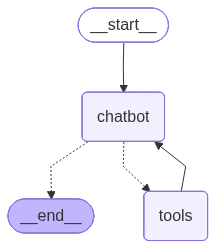

In [14]:
from IPython.display import display, Image

# Visualize the chatbot's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

In [15]:
from IPython.display import Markdown, display

def render_markdown(md_string):
    display(Markdown(md_string))

def process_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
    return message

def process_query(query, config=None):
    inputs = {"messages": [("user", query)]}
    message = process_stream(graph.stream(inputs, config, stream_mode="values"))
    render_markdown(f"## Answer:\n{message.content}")

In [16]:
process_query("Hello! What can you do?")


================================ Human Message =================================

Hello! What can you do?
================================== Ai Message ==================================

Hey there! I’m ChatGPT, a versatile AI assistant that can help you with a wide range of tasks, such as:

- **Answering questions** – from everyday facts to deeper explanations in science, history, tech, art, and more.  
- **Research & up‑to‑date info** – I can run a quick DuckDuckGo search for the latest news, recent studies, product specs, etc.  
- **Writing & editing** – drafts, essays, emails, stories, poems, resumes, cover letters, reports, and even social‑media posts.  
- **Programming help** – explain concepts, debug code, write snippets in many languages, suggest algorithms, or walk you through a project.  
- **Learning & tutoring** – break down complex topics, create practice problems, generate flashcards, or design study plans.  
- **Creative brainstorming** – ideas for businesses, marketing 

## Answer:
Hey there! I’m ChatGPT, a versatile AI assistant that can help you with a wide range of tasks, such as:

- **Answering questions** – from everyday facts to deeper explanations in science, history, tech, art, and more.  
- **Research & up‑to‑date info** – I can run a quick DuckDuckGo search for the latest news, recent studies, product specs, etc.  
- **Writing & editing** – drafts, essays, emails, stories, poems, resumes, cover letters, reports, and even social‑media posts.  
- **Programming help** – explain concepts, debug code, write snippets in many languages, suggest algorithms, or walk you through a project.  
- **Learning & tutoring** – break down complex topics, create practice problems, generate flashcards, or design study plans.  
- **Creative brainstorming** – ideas for businesses, marketing campaigns, games, gifts, party themes, travel itineraries, recipes, and more.  
- **Data & math** – perform calculations, generate tables or simple visualizations, explain statistics, solve equations, etc.  
- **Productivity support** – make to‑do lists, outline meeting agendas, draft schedules, set reminders (via external tools), and help you stay organized.  
- **Conversational companion** – chat about books, movies, philosophy, hobbies, or just have a friendly conversation.

I also have a couple of built‑in tools:

- **`duckduckgo_results_json`** – lets me fetch live search results for the latest information.  
- **`get_current_date`** – gives me today’s date in YYYY‑MM‑DD format.

Just let me know what you need, and I’ll dive in! 🚀

In [17]:
# Query that requires current date
process_query("What is the current date?")

================================ Human Message =================================

What is the current date?
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_sdes9j3r)
 Call ID: call_sdes9j3r
  Args:
================================= Tool Message =================================
Name: get_current_date

2026-02-19
================================== Ai Message ==================================

Today's date is **2026‑02‑19**.


## Answer:
Today's date is **2026‑02‑19**.

In [18]:
# Query that triggers the Tavily search tool
process_query("What is LangGraph?")

================================ Human Message =================================

What is LangGraph?
================================== Ai Message ==================================

**LangGraph – a quick‑look overview**

| Aspect | What it is | Why it matters |
|--------|------------|----------------|
| **Type** | An open‑source Python library (and now a first‑class component of the LangChain ecosystem) that lets you describe, build, and run **graph‑structured LLM workflows**. | Turns a linear chain of prompts into a full‑featured, stateful, branching “program” that can loop, make decisions, call tools, and maintain context. |
| **Core idea** | Treat each step of an LLM‑powered application (prompt, tool call, function, retrieval, agent, etc.) as a **node** in a directed graph. Edges encode the flow of data (the *state*) from one node to the next. | Gives you a visual, modular, and debuggable way to compose complex multi‑turn interactions—think “if‑else”, “while”, “fork‑join”, or “re‑t

## Answer:
**LangGraph – a quick‑look overview**

| Aspect | What it is | Why it matters |
|--------|------------|----------------|
| **Type** | An open‑source Python library (and now a first‑class component of the LangChain ecosystem) that lets you describe, build, and run **graph‑structured LLM workflows**. | Turns a linear chain of prompts into a full‑featured, stateful, branching “program” that can loop, make decisions, call tools, and maintain context. |
| **Core idea** | Treat each step of an LLM‑powered application (prompt, tool call, function, retrieval, agent, etc.) as a **node** in a directed graph. Edges encode the flow of data (the *state*) from one node to the next. | Gives you a visual, modular, and debuggable way to compose complex multi‑turn interactions—think “if‑else”, “while”, “fork‑join”, or “re‑try until success” patterns. |
| **Key building blocks** | 1. **Node / Runnable** – a callable that receives a **State** (a dict‑like object) and returns an updated State.  <br>2. **State** – the shared context that travels along edges (messages, retrieved docs, tool results, flags, counters, etc.). <br>3. **Graph** – a collection of nodes + edges, usually defined with a simple DSL (`graph.add_edge("A", "B")` or via a `graph.yaml`). <br>4. **Condition / Trigger** – functions that decide which outgoing edge to follow based on the current state. <br>5. **Loop / Sub‑graph** – you can nest graphs or create loops that re‑enter a node until a predicate is satisfied. | These abstractions let you write “LLM programs” that look more like ordinary Python code (or a visual flowchart) rather than a long chain of `chain.run()` calls. |
| **How it fits with LangChain** | LangGraph re‑uses LangChain’s `Runnable` interface, `PromptTemplate`, `ChatOpenAI` (or any other LLM), `retrievers`, `tools`, and callbacks. It’s essentially the **graph‑oriented sibling** of LangChain’s `Chain` and `Agent` abstractions. | If you already use LangChain, you can drop in a `Graph` with almost no friction. If you need more expressive control flow than a linear chain, LangGraph is the natural next step. |
| **Typical use‑cases** | • Multi‑turn agents that need to *think*, *search*, *act*, and *reflect* (e.g., research assistants). <br>• Decision‑making pipelines (e.g., “classify → route to tool A/B → post‑process”). <br>• Looped refinement (e.g., “generate answer → self‑critique → revise until confidence > 0.9”). <br>• Orchestrating several tools: retrieval → summarization → Q&A → database write. | Anything that involves **stateful, conditional, or iterative** interactions with LLMs and external resources. |
| **Visualization** | Built‑in support for **GraphViz / Mermaid** rendering. You can call `graph.draw()` (or `graph.visualize()`) to get a PNG/SVG or an interactive HTML diagram that shows node names, edge conditions, and current state values. | Makes debugging, documentation, and stakeholder communication much easier. |
| **Installation** | ```bash\npip install langgraph\n``` | Works with Python 3.9+. It pulls in LangChain as a dependency, so you already have the LLM wrappers. |
| **Simple example** | ```python\nfrom langgraph.graph import StateGraph, START, END\nfrom langchain.chat_models import ChatOpenAI\nfrom langchain.prompts import PromptTemplate\n\n# 1️⃣ Define nodes\n\ndef generate(state):\n    llm = ChatOpenAI()\n    prompt = PromptTemplate.from_template(\"Answer the question: {question}\")\n    answer = llm.invoke(prompt.format(question=state[\"question\"]))\n    state[\"answer\"] = answer.content\n    return state\n\ndef check_quality(state):\n    # Very naive quality check – e.g., length > 20 chars\n    state[\"good\"] = len(state[\"answer\"]) > 20\n    return state\n\n# 2️⃣ Build the graph\n\ng = StateGraph(START)\n\ng.add_node(\"generate\", generate)\n\ng.add_node(\"check\", check_quality)\n\ng.add_edge(START, \"generate\")\n\ng.add_conditional_edges(\n    \"generate\",\n    lambda s: \"check\" if s[\"good\"] else END,  # if answer good → check, else finish early\n)\n\ng.add_edge(\"check\", END)\n\n# 3️⃣ Run it\nworkflow = g.compile()\nresult = workflow.invoke({\"question\": \"What is quantum tunnelling?\"})\nprint(result[\"answer\"])\n```\nThe graph runs *generate → check → END* (or skips to END if the condition fails). | Shows how a tiny graph replaces several separate chain objects and gives you an explicit control flow. |
| **Advanced features** | • **Async support** – nodes can be `async def` and the whole graph can be executed with `await`. <br>• **Streaming** – hook into LLM token streams via LangChain callbacks. <br>• **Memory integration** – you can attach a `Memory` object to the graph so that each run automatically sees previous states. <br>• **Tool adapters** – export a graph as a LangChain `Agent` so that external callers can treat it like a single tool. | Enables production‑grade pipelines (async APIs, partial responses, persistent memory). |
| **Where to learn more** | • **Docs** – https://langchain.com/langgraph <br>• **GitHub repo** – https://github.com/langchain-ai/langgraph (readme, examples, tutorial notebooks). <br>• **Blog posts** – “Building Loopy LLM Agents with LangGraph” (LangChain blog, Oct 2023). <br>• **YouTube** – “LangGraph Deep Dive” (LangChain channel). | Good starting points for hands‑on experimentation. |
| **Community & Ecosystem** | • Active Discord/Slack channel under the LangChain community. <br>• A growing list of community‑contributed graph templates (e.g., “research‑assistant”, “code‑review‑loop”). <br>• Compatibility with LangServe, LangSmith observability, and LangFuse for monitoring. | You can reuse patterns or request help quickly. |

---

### TL;DR (one‑sentence definition)

**LangGraph is a graph‑based orchestration framework for LLM applications that lets you define nodes (prompt/tool steps) and conditional/looping edges, enabling complex, stateful, and visualizable workflows built on top of LangChain.**

If you’re already using LangChain and find yourself writing long, linear chains or custom “if‑else” code around LLM calls, LangGraph gives you a clean, modular, and debuggable way to turn that logic into an explicit graph.

In [19]:
# Time-based query about an event
process_query("When is the next olympics?")

================================ Human Message =================================

When is the next olympics?
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_eca4n7pz)
 Call ID: call_eca4n7pz
  Args:
================================= Tool Message =================================
Name: get_current_date

2026-02-19
================================== Ai Message ==================================

The next edition of the Olympic Games is the **2026 Winter Olympics** in **Milan‑Cortina d’Ampezzo, Italy**.  
- **Dates:** **6 – 22 February 2026** (the Games are already underway as of today).

The following Olympic Games after that will be the **2028 Summer Olympics** in **Los Angeles, USA**.  
- **Dates:** **21 July – 6 August 2028**.


## Answer:
The next edition of the Olympic Games is the **2026 Winter Olympics** in **Milan‑Cortina d’Ampezzo, Italy**.  
- **Dates:** **6 – 22 February 2026** (the Games are already underway as of today).

The following Olympic Games after that will be the **2028 Summer Olympics** in **Los Angeles, USA**.  
- **Dates:** **21 July – 6 August 2028**.

In [20]:
process_query("Hi. My name is bappi. Who are you?")


================================ Human Message =================================

Hi. My name is bappi. Who are you?
================================== Ai Message ==================================

Hello, Bappi! 👋 I'm ChatGPT, an AI language model created by OpenAI. I’m here to answer questions, brainstorm ideas, help with writing, explain concepts, or just have a friendly chat—whatever you need. How can I help you today?


## Answer:
Hello, Bappi! 👋 I'm ChatGPT, an AI language model created by OpenAI. I’m here to answer questions, brainstorm ideas, help with writing, explain concepts, or just have a friendly chat—whatever you need. How can I help you today?

In [21]:
process_query("What is my name?")


================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I don’t actually have any information about your name. Could you let me know what you’d like me to call you?


## Answer:
I don’t actually have any information about your name. Could you let me know what you’d like me to call you?

In [22]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [24]:
# Compile the graph with the checkpointer
graph = graph_builder.compile(checkpointer=memory)

In [25]:
config_user_1 = {"thread_id": "user_1"}
process_query("Hi. My name is Sajal. Who are you?", config=config_user_1)

================================ Human Message =================================

Hi. My name is Sajal. Who are you?
================================== Ai Message ==================================

Hello Sajal! I’m ChatGPT, an AI language model created by OpenAI. I can help answer questions, brainstorm ideas, explain concepts, draft writing, troubleshoot problems, and much more. Feel free to let me know what you’d like to talk about or explore!


## Answer:
Hello Sajal! I’m ChatGPT, an AI language model created by OpenAI. I can help answer questions, brainstorm ideas, explain concepts, draft writing, troubleshoot problems, and much more. Feel free to let me know what you’d like to talk about or explore!

In [26]:
process_query("What is my name?", config=config_user_1)


================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

You told me your name is **Sajal**. Nice to meet you!


## Answer:
You told me your name is **Sajal**. Nice to meet you!

In [27]:
# Checking if memory is shared across threads
config_user_2 = {"thread_id": "user_2"}
process_query("What is my name?", config=config_user_2)

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I’m sorry, but I don’t have any information about your name. If you’d like to share it, I’ll be happy to address you by it!


## Answer:
I’m sorry, but I don’t have any information about your name. If you’d like to share it, I’ll be happy to address you by it!